# RNN/LSTM 中文影评情感分类实验

这个Notebook实现了使用RNN和LSTM进行中文影评情感分类的任务。实验使用ChnSentiCorp酒店评论数据集，对比了两种模型的性能差异。

## RNN 自回归任务

这部分实现了一个简单的字符级RNN模型用于自回归任务。

In [76]:
import torch
from torch import nn
import numpy as np
vocab_size=32 # 示例值，实际会根据文本计算
# 定义句子
text = ['hey how are you','good i am fine','have a nice day']

# 连接所有句子并提取唯一字符
chars = set(''.join(text))

# 创建映射整数到字符的字典
int2char = dict(enumerate(chars))

# 创建映射字符到整数的字典
char2int = {char: ind for ind, char in int2char.items()}

print(char2int)
print(int2char)

{' ': 0, 'w': 1, 'f': 2, 'c': 3, 'r': 4, 'm': 5, 'u': 6, 'i': 7, 'e': 8, 'y': 9, 'g': 10, 'v': 11, 'o': 12, 'n': 13, 'h': 14, 'a': 15, 'd': 16}
{0: ' ', 1: 'w', 2: 'f', 3: 'c', 4: 'r', 5: 'm', 6: 'u', 7: 'i', 8: 'e', 9: 'y', 10: 'g', 11: 'v', 12: 'o', 13: 'n', 14: 'h', 15: 'a', 16: 'd'}


In [77]:
# 设置随机种子以保证实验的可重复性
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("随机种子已设置为", SEED)

# 导入所需库
import gensim
import jieba
import os
from torch.utils.data import Dataset, DataLoader
from torch.functional import F
import pandas as pd 

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 主任务设备
print(f"Using device for sentiment classification: {device}")

# Matplotlib 中文显示设置
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

随机种子已设置为 42
Using device for sentiment classification: cuda


### 数据预处理与加载

In [78]:
class RNNDataset(Dataset):
    def __init__(self, data, word2vec_model, seq_len, word_len=100):
        label = data['label'].to_numpy().astype(np.float32)
        self.word2vec_model = word2vec_model
        self.data = [list(jieba.cut(str(sentence))) for sentence in data['review'].to_list()]
        self.label = torch.from_numpy(label).unsqueeze(-1)
        self.seq_len = seq_len
        self.word_len = word_len        

    def preprocess(self, sentence):
        valid_words = [word for word in sentence if word in self.word2vec_model.wv]
        if not valid_words:
            return torch.zeros((self.seq_len, self.word_len), dtype=torch.float32)

        sentence_vectors = np.array([self.word2vec_model.wv[word] for word in valid_words], dtype=np.float32)
        sentence_tensor = torch.from_numpy(sentence_vectors)
        
        current_len = sentence_tensor.shape[0]
        if current_len == 0:
             return torch.zeros((self.seq_len, self.word_len), dtype=torch.float32)

        if current_len > self.seq_len:
            sentence_tensor = sentence_tensor[:self.seq_len, :]
        elif current_len < self.seq_len:
            padding_size = self.seq_len - current_len
            sentence_tensor = F.pad(sentence_tensor, (0, 0, 0, padding_size), 'constant', 0)
        return sentence_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]
        label = self.label[idx]
        return self.preprocess(sentence), label

In [79]:
def build_word2vec_model(data, word_len, model_dir='./model', model_name='word2vec.model'):
    sentences = [list(jieba.cut(str(sentence))) for sentence in data['review'].to_list()]
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = os.path.join(model_dir, model_name)
        
    if os.path.exists(model_path):
        print(f"Loading existing Word2Vec model from {model_path}")
        word2vec_model = gensim.models.Word2Vec.load(model_path)
    else:
        print(f"Building new Word2Vec model and saving to {model_path}")
        word2vec_model = gensim.models.Word2Vec(sentences, vector_size=word_len, window=5, min_count=1, workers=4)
        word2vec_model.save(model_path)
    return word2vec_model

In [80]:
def get_dataloader(data_path, seq_len, word_len, batch_size, model_dir='./model'):
    try:
        data_df = pd.read_csv(data_path)
    except Exception as e:
        print(f"Error loading data from {data_path}: {e}")
        print("Using sample data instead.")
        sample_reviews = [
            '这家酒店环境很好，服务周到。', '房间太小了，性价比不高。', 
            '早餐种类丰富，味道不错。', '隔音效果差，晚上很吵。', 
            '地理位置优越，出行方便。', '设施陈旧，体验不佳。',
            '服务员态度热情，点赞。', '网络信号不稳定。',
            '强烈推荐这家！', '不会再来了。'
        ]
        sample_labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
        data_df = pd.DataFrame({'review': sample_reviews, 'label': sample_labels})

    if 'review' not in data_df.columns or 'label' not in data_df.columns:
        raise ValueError("DataFrame必须包含'review'和'label'列。")

    data_df = data_df.dropna(subset=['review', 'label'], axis=0, how='any')
    data_df['review'] = data_df['review'].astype(str)
    data_df['label'] = data_df['label'].astype(int)

    if data_df.empty:
        raise ValueError("数据清洗后为空。请检查您的数据文件。")

    word2vec_model = build_word2vec_model(data_df, word_len, model_dir=model_dir)
    
    idx = np.arange(data_df.shape[0])
    np.random.shuffle(idx)
    data_df_shuffled = data_df.iloc[idx]
    
    split_ratio = 0.8
    train_test_split_index = int(data_df_shuffled.shape[0] * split_ratio)

    if train_test_split_index == 0 or train_test_split_index == data_df_shuffled.shape[0]:
        raise ValueError(f"训练/测试分割产生了一个空集合。总样本数：{data_df_shuffled.shape[0]}，分割索引：{train_test_split_index}。请调整数据或分割比例。")
    
    train_data = data_df_shuffled.iloc[:train_test_split_index]
    test_data = data_df_shuffled.iloc[train_test_split_index:]
    
    train_dataset = RNNDataset(train_data, word2vec_model, seq_len, word_len)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 
    
    test_dataset = RNNDataset(test_data, word2vec_model, seq_len, word_len)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Data loaded: {len(data_df)} total reviews.")
    print(f"Train Dataloader: {len(train_dataloader.dataset)} samples, {len(train_dataloader)} batches.")
    print(f"Test Dataloader: {len(test_dataloader.dataset)} samples, {len(test_dataloader)} batches.")
    
    return train_dataloader, test_dataloader

In [81]:
import torch.nn as nn # 确保nn被导入
import torch.optim as optim # 确保optim被导入
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns # 确保sns被导入

# 数据加载参数
DATA_FILE_PATH = "data/ChnSentiCorp_htl_all.csv"
SEQ_LEN = 50
WORD_LEN = 100
BATCH_SIZE = 64
MODEL_DIR = './model_w2v'

if not os.path.exists(DATA_FILE_PATH) and DATA_FILE_PATH != "data/sample_reviews.csv":
    print(f"警告: 数据文件 {DATA_FILE_PATH} 未找到。")

In [82]:
try:
    train_loader, test_loader = get_dataloader(DATA_FILE_PATH, SEQ_LEN, WORD_LEN, BATCH_SIZE, model_dir=MODEL_DIR)
    print(f"成功创建 DataLoader。")
    
    if train_loader and len(train_loader.dataset) > 0:
        print(f"训练集样本数: {len(train_loader.dataset)}")
        sample_batch_text, sample_batch_labels = next(iter(train_loader))
        print(f"一批训练数据的形状: {sample_batch_text.shape}")
        print(f"一批训练标签的形状: {sample_batch_labels.shape}")
    else:
        print("训练数据加载器为空或没有数据。")

    if test_loader and len(test_loader.dataset) > 0:
        print(f"测试集样本数: {len(test_loader.dataset)}")
    else:
        print("测试数据加载器为空或没有数据。")

except Exception as e:
    print(f"创建 DataLoader 时出错: {e}")
    print("请检查 get_dataloader 函数和数据文件路径。")

Loading existing Word2Vec model from ./model_w2v\word2vec.model
Data loaded: 7765 total reviews.
Train Dataloader: 6212 samples, 98 batches.
Test Dataloader: 1553 samples, 25 batches.
成功创建 DataLoader。
训练集样本数: 6212
一批训练数据的形状: torch.Size([64, 50, 100])
一批训练标签的形状: torch.Size([64, 1])
测试集样本数: 1553
Data loaded: 7765 total reviews.
Train Dataloader: 6212 samples, 98 batches.
Test Dataloader: 1553 samples, 25 batches.
成功创建 DataLoader。
训练集样本数: 6212
一批训练数据的形状: torch.Size([64, 50, 100])
一批训练标签的形状: torch.Size([64, 1])
测试集样本数: 1553


### 模型定义

#### RNN模型实现

In [83]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout_prob, use_embedding=True, vocab_size=None, embedding_dim=None, pad_idx=None):
        super().__init__()
        self.use_embedding = use_embedding
        if self.use_embedding:
            if vocab_size is None or embedding_dim is None:
                raise ValueError("vocab_size and embedding_dim must be provided if use_embedding is True.")
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
            rnn_input_dim = embedding_dim
        else:
            rnn_input_dim = input_dim
            
        self.rnn = nn.RNN(rnn_input_dim, 
                         hidden_dim, 
                         num_layers=n_layers, 
                         bidirectional=True, 
                         batch_first=True,
                         dropout=dropout_prob if n_layers > 1 else 0)
                         
        fc_input_dim = hidden_dim * 2
        self.fc1 = nn.Linear(fc_input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, text_input):
        if self.use_embedding:
            embedded = self.dropout(self.embedding(text_input))
        else:
            embedded = self.dropout(text_input)
        
        output, hidden = self.rnn(embedded)
        
        if self.rnn.bidirectional:
            final_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            final_hidden_state = hidden[-1,:,:]
            
        dense1 = self.fc1(self.dropout(final_hidden_state))
        dense1 = self.batch_norm(dense1)
        dense1 = self.act(dense1)
        output = self.fc2(self.dropout(dense1))
        
        return output

#### LSTM模型实现（带注意力机制）

In [84]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_prob, use_embedding=True, vocab_size=None, embedding_dim=None, pad_idx=None):
        super().__init__()
        self.use_embedding = use_embedding
        if self.use_embedding:
            if vocab_size is None or embedding_dim is None:
                raise ValueError("vocab_size and embedding_dim must be provided if use_embedding is True.")
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
            lstm_input_dim = embedding_dim
        else:
            lstm_input_dim = input_dim
        
        self.lstm = nn.LSTM(lstm_input_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           batch_first=True,
                           dropout=dropout_prob if n_layers > 1 else 0)
        
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.attention = nn.Linear(fc_input_dim, 1)
        
        self.fc1 = nn.Linear(fc_input_dim, fc_input_dim // 2)
        self.act = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(fc_input_dim // 2)
        self.fc2 = nn.Linear(fc_input_dim // 2, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        
    def attention_net(self, lstm_output):
        attn_weights = F.softmax(self.attention(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context
        
    def forward(self, text_input):
        if self.use_embedding:
            embedded = self.dropout(self.embedding(text_input))
        else:
            embedded = self.dropout(text_input)
        
        lstm_output, (hidden, cell) = self.lstm(embedded)
        attn_output = self.attention_net(lstm_output)
        
        dense1 = self.fc1(self.dropout(attn_output))
        dense1 = self.batch_norm(dense1)
        dense1 = self.act(dense1)
        output = self.fc2(self.dropout(dense1))
        
        return output

### 训练和评估函数

In [85]:
def train_model(model, iterator, optimizer, criterion, scheduler=None, clip=1.0):
    epoch_loss = 0
    epoch_acc = 0 
    
    model.train()
    
    if not iterator or len(iterator) == 0:
        print("训练迭代器为空，跳过训练。")
        return 0, 0

    for batch_idx, (text_batch, labels_batch) in enumerate(iterator):
        text_batch = text_batch.to(device)
        labels_batch = labels_batch.to(device) 
        
        optimizer.zero_grad()
        predictions = model(text_batch) 
        
        if isinstance(criterion, nn.BCEWithLogitsLoss):
            predictions = predictions.squeeze(-1) if predictions.dim() > 1 and predictions.size(-1) == 1 else predictions
            labels_batch = labels_batch.squeeze(-1).float() if labels_batch.dim() > 1 and labels_batch.size(-1) == 1 else labels_batch.float()
            loss = criterion(predictions, labels_batch)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            correct = (rounded_preds == labels_batch).float()
            acc = correct.sum() / len(correct)
        elif isinstance(criterion, nn.CrossEntropyLoss):
            labels_batch = labels_batch.squeeze(-1).long() if labels_batch.dim() > 1 and labels_batch.size(-1) == 1 else labels_batch.long()
            loss = criterion(predictions, labels_batch)
            top_p, top_class = predictions.topk(1, dim=1)
            correct = (top_class.squeeze(1) == labels_batch).float()
            acc = correct.sum() / len(correct)
        else:
            raise ValueError("不支持的损失函数类型")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    avg_epoch_loss = epoch_loss / len(iterator)
    if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(avg_epoch_loss) # ReduceLROnPlateau需要监控指标
    elif scheduler is not None: # 其他类型的调度器
        scheduler.step()
        
    return avg_epoch_loss, epoch_acc / len(iterator)

In [86]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'验证损失减少 ({self.val_loss_min:.6f} --> {val_loss:.6f})。保存模型...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [87]:
def evaluate_model(model, iterator, criterion):
    epoch_loss = 0
    all_preds_list = []
    all_labels_list = []
    
    model.eval()

    if not iterator or len(iterator) == 0:
        print("评估迭代器为空，跳过评估。")
        return 0, 0, np.array([]), [], []
    
    with torch.no_grad():
        for text_batch, labels_batch in iterator:
            text_batch = text_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            predictions = model(text_batch)
            
            current_labels_np = (labels_batch.squeeze(-1).cpu().numpy() if labels_batch.dim() > 1 and labels_batch.size(-1) == 1 else labels_batch.cpu().numpy())
            all_labels_list.extend(current_labels_np)

            if isinstance(criterion, nn.BCEWithLogitsLoss):
                predictions_squeezed = predictions.squeeze(-1) if predictions.dim() > 1 and predictions.size(-1) == 1 else predictions
                labels_batch_squeezed = labels_batch.squeeze(-1).float() if labels_batch.dim() > 1 and labels_batch.size(-1) == 1 else labels_batch.float()
                loss = criterion(predictions_squeezed, labels_batch_squeezed)
                rounded_preds = torch.round(torch.sigmoid(predictions_squeezed))
                all_preds_list.extend(rounded_preds.cpu().numpy())
            elif isinstance(criterion, nn.CrossEntropyLoss):
                labels_batch_squeezed = labels_batch.squeeze(-1).long() if labels_batch.dim() > 1 and labels_batch.size(-1) == 1 else labels_batch.long()
                loss = criterion(predictions, labels_batch_squeezed)
                top_p, top_class = predictions.topk(1, dim=1)
                all_preds_list.extend(top_class.squeeze(1).cpu().numpy())
            else:
                raise ValueError("不支持的损失函数类型")

            epoch_loss += loss.item()
            
    if not all_labels_list or not all_preds_list:
        print("没有标签或预测结果可用于计算指标。")
        return epoch_loss / len(iterator) if len(iterator) > 0 else 0, 0, np.array([]), [], []

    all_labels_np = np.array(all_labels_list)
    all_preds_np = np.array(all_preds_list)

    final_accuracy = accuracy_score(all_labels_np.astype(int), all_preds_np.astype(int))
    cm = confusion_matrix(all_labels_np.astype(int), all_preds_np.astype(int))
    
    return epoch_loss / len(iterator), final_accuracy, cm, all_labels_np, all_preds_np

In [88]:
def plot_loss_curves(train_losses, val_losses, title_prefix=""):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='训练损失 (Train Loss)')
    if val_losses: 
        plt.plot(val_losses, label='验证损失 (Validation Loss)')
    plt.title(f'{title_prefix} 训练和验证损失曲线')
    plt.xlabel('轮次 (Epochs)')
    plt.ylabel('损失 (Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, class_names, title_prefix=""):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title_prefix} 混淆矩阵 (Confusion Matrix)')
    plt.xlabel('预测标签 (Predicted Label)')
    plt.ylabel('真实标签 (True Label)')
    plt.show()

### 模型配置及初始化

In [89]:
# 全局参数设置
USING_PRECOMPUTED_EMBEDDINGS = True 
EMBEDDING_DIM_MODEL = WORD_LEN # 使用已定义的WORD_LEN
OUTPUT_DIM = 1 # 二分类任务

# RNN (RNNModel) 参数
# --- 可调超参数 ---
# RNN_INPUT_DIM: 通常由词向量维度决定 (EMBEDDING_DIM_MODEL)
# HIDDEN_DIM_RNN: GRU隐藏层单元数。可尝试范围如 [128, 256, 512]。增加此值可增强模型容量，但也可能增加过拟合风险。
# N_LAYERS_RNN: GRU层数。可尝试范围如 [1, 2, 3]。更多层可以学习更复杂的特征，但也更难训练。
# DROPOUT_RNN: Dropout比例，用于正则化，防止过拟合。可尝试范围如 [0.2, 0.3, 0.4, 0.5]。
# LEARNING_RATE_RNN: 学习率。可尝试范围如 [0.0001, 0.0005, 0.001, 0.005]。
# WEIGHT_DECAY_RNN: L2正则化系数。可尝试范围如 [1e-6, 1e-5, 1e-4]。
# ------------------
RNN_INPUT_DIM = EMBEDDING_DIM_MODEL 
HIDDEN_DIM_RNN = 256 
N_LAYERS_RNN = 2     
DROPOUT_RNN = 0.5    

rnn_model = RNNModel(input_dim=RNN_INPUT_DIM,
                     hidden_dim=HIDDEN_DIM_RNN, 
                     output_dim=OUTPUT_DIM, 
                     n_layers=N_LAYERS_RNN, 
                     dropout_prob=DROPOUT_RNN,
                     use_embedding=False, # 因为我们使用预计算的Word2Vec
                    ).to(device)

LEARNING_RATE_RNN = 0.001
WEIGHT_DECAY_RNN = 1e-5
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE_RNN, weight_decay=WEIGHT_DECAY_RNN)
# ReduceLROnPlateau: 当验证损失在patience轮内不再下降时，降低学习率。
scheduler_rnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rnn, mode='min', factor=0.5, patience=3)
criterion_rnn = nn.BCEWithLogitsLoss().to(device) if OUTPUT_DIM == 1 else nn.CrossEntropyLoss().to(device)
# EarlyStopping: 当验证损失在patience轮内不再改善时，提前停止训练，防止过拟合，并保存最佳模型。
early_stopping_rnn = EarlyStopping(patience=5, verbose=True, path='best_rnn_model.pt')

print("RNN 模型结构:")
print(rnn_model)

RNN 模型结构:
RNNModel(
  (rnn): RNN(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [90]:
# LSTM (LSTMModel) 参数
# --- 可调超参数 ---
# LSTM_INPUT_DIM: 通常由词向量维度决定 (EMBEDDING_DIM_MODEL)
# HIDDEN_DIM_LSTM: LSTM隐藏层单元数。可尝试范围如 [128, 256, 512]。
# N_LAYERS_LSTM: LSTM层数。可尝试范围如 [1, 2, 3]。
# BIDIRECTIONAL_LSTM: 是否使用双向LSTM。True通常更好，因为它能同时考虑过去和未来的上下文。
# DROPOUT_LSTM: Dropout比例。可尝试范围如 [0.2, 0.3, 0.4, 0.5]。
# LEARNING_RATE_LSTM: 学习率。可尝试范围如 [0.0001, 0.0005, 0.001, 0.005]。
# WEIGHT_DECAY_LSTM: L2正则化系数。可尝试范围如 [1e-6, 1e-5, 1e-4]。
# ------------------
LSTM_INPUT_DIM = EMBEDDING_DIM_MODEL
HIDDEN_DIM_LSTM = 256
N_LAYERS_LSTM = 2
BIDIRECTIONAL_LSTM = True
DROPOUT_LSTM = 0.5

lstm_model = LSTMModel(input_dim=LSTM_INPUT_DIM,
                       hidden_dim=HIDDEN_DIM_LSTM, 
                       output_dim=OUTPUT_DIM, 
                       n_layers=N_LAYERS_LSTM, 
                       bidirectional=BIDIRECTIONAL_LSTM, 
                       dropout_prob=DROPOUT_LSTM,
                       use_embedding=False, # 因为我们使用预计算的Word2Vec
                      ).to(device)

LEARNING_RATE_LSTM = 0.001
WEIGHT_DECAY_LSTM = 1e-5
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE_LSTM, weight_decay=WEIGHT_DECAY_LSTM)
# ReduceLROnPlateau: 当验证损失在patience轮内不再下降时，降低学习率。
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode='min', factor=0.5, patience=3)
criterion_lstm = nn.BCEWithLogitsLoss().to(device) if OUTPUT_DIM == 1 else nn.CrossEntropyLoss().to(device)
# EarlyStopping: 当验证损失在patience轮内不再改善时，提前停止训练，防止过拟合，并保存最佳模型。
early_stopping_lstm = EarlyStopping(patience=5, verbose=True, path='best_lstm_model.pt')

print("LSTM 模型结构:")
print(lstm_model)

LSTM 模型结构:
LSTMModel(
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (act): ReLU()
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### 模型训练

In [91]:
# 训练RNN模型
N_EPOCHS = 30 # 训练轮次，可根据收敛情况和早停调整
rnn_train_losses = []
rnn_val_losses = [] # 用于早停和学习率调度

print("开始训练 RNN 模型...")
if not list(train_loader): # 确保 train_loader 非空
    print("错误：训练数据加载器为空。无法开始训练。请检查数据预处理步骤。")
else:
    for epoch in range(N_EPOCHS):
        # 训练阶段
        train_loss, train_acc = train_model(rnn_model, train_loader, optimizer_rnn, criterion_rnn, scheduler=None) # ReduceLROnPlateau 在验证后step
        # 验证阶段
        val_loss, val_acc, _, _, _ = evaluate_model(rnn_model, test_loader, criterion_rnn) # 使用test_loader作为验证集
        
        rnn_train_losses.append(train_loss)
        rnn_val_losses.append(val_loss)
        
        print(f'RNN Epoch: {epoch+1:02}')
        print(f'\t训练损失: {train_loss:.3f} | 训练准确率: {train_acc*100:.2f}%')
        print(f'\t验证损失: {val_loss:.3f} | 验证准确率: {val_acc*100:.2f}%')
        
        # 根据验证损失调整学习率
        scheduler_rnn.step(val_loss) 
        # 早停检查
        early_stopping_rnn(val_loss, rnn_model)
        if early_stopping_rnn.early_stop:
            print("早停触发")
            break
    print("RNN 模型训练完成。")
    # 加载性能最佳的模型权重
    if os.path.exists(early_stopping_rnn.path):
        print(f"加载最佳RNN模型: {early_stopping_rnn.path}")
        rnn_model.load_state_dict(torch.load(early_stopping_rnn.path))

开始训练 RNN 模型...
RNN Epoch: 01
	训练损失: 0.672 | 训练准确率: 64.17%
	验证损失: 0.695 | 验证准确率: 31.36%
验证损失减少 (inf --> 0.694715)。保存模型...
RNN Epoch: 01
	训练损失: 0.672 | 训练准确率: 64.17%
	验证损失: 0.695 | 验证准确率: 31.36%
验证损失减少 (inf --> 0.694715)。保存模型...
RNN Epoch: 02
	训练损失: 0.644 | 训练准确率: 67.54%
	验证损失: 0.681 | 验证准确率: 68.64%
验证损失减少 (0.694715 --> 0.681212)。保存模型...
RNN Epoch: 02
	训练损失: 0.644 | 训练准确率: 67.54%
	验证损失: 0.681 | 验证准确率: 68.64%
验证损失减少 (0.694715 --> 0.681212)。保存模型...
RNN Epoch: 03
	训练损失: 0.634 | 训练准确率: 68.75%
	验证损失: 0.674 | 验证准确率: 68.64%
验证损失减少 (0.681212 --> 0.674356)。保存模型...
RNN Epoch: 03
	训练损失: 0.634 | 训练准确率: 68.75%
	验证损失: 0.674 | 验证准确率: 68.64%
验证损失减少 (0.681212 --> 0.674356)。保存模型...
RNN Epoch: 04
	训练损失: 0.628 | 训练准确率: 68.81%
	验证损失: 0.682 | 验证准确率: 68.64%
EarlyStopping counter: 1 out of 5
RNN Epoch: 04
	训练损失: 0.628 | 训练准确率: 68.81%
	验证损失: 0.682 | 验证准确率: 68.64%
EarlyStopping counter: 1 out of 5
RNN Epoch: 05
	训练损失: 0.628 | 训练准确率: 68.83%
	验证损失: 0.669 | 验证准确率: 68.64%
验证损失减少 (0.674356 --> 0.669441)。保存模型...
RNN Ep

In [92]:
# 训练LSTM模型
# N_EPOCHS 与 RNN 模型保持一致或独立设置
lstm_train_losses = []
lstm_val_losses = [] # 用于早停和学习率调度

print("开始训练 LSTM 模型...")
if not list(train_loader): # 确保 train_loader 非空
    print("错误：训练数据加载器为空。无法开始训练。")
else:
    for epoch in range(N_EPOCHS): # 使用与RNN相同的N_EPOCHS或单独设置
        # 训练阶段
        train_loss, train_acc = train_model(lstm_model, train_loader, optimizer_lstm, criterion_lstm, scheduler=None) # ReduceLROnPlateau 在验证后step
        # 验证阶段
        val_loss, val_acc, _, _, _ = evaluate_model(lstm_model, test_loader, criterion_lstm)
        
        lstm_train_losses.append(train_loss)
        lstm_val_losses.append(val_loss)
        
        print(f'LSTM Epoch: {epoch+1:02}')
        print(f'\t训练损失: {train_loss:.3f} | 训练准确率: {train_acc*100:.2f}%')
        print(f'\t验证损失: {val_loss:.3f} | 验证准确率: {val_acc*100:.2f}%')
        
        # 根据验证损失调整学习率
        scheduler_lstm.step(val_loss)
        # 早停检查
        early_stopping_lstm(val_loss, lstm_model)
        if early_stopping_lstm.early_stop:
            print("早停触发")
            break
    print("LSTM 模型训练完成。")
    # 加载性能最佳的模型权重
    if os.path.exists(early_stopping_lstm.path):
        print(f"加载最佳LSTM模型: {early_stopping_lstm.path}")
        lstm_model.load_state_dict(torch.load(early_stopping_lstm.path))

开始训练 LSTM 模型...
LSTM Epoch: 01
	训练损失: 0.672 | 训练准确率: 64.27%
	验证损失: 0.638 | 验证准确率: 68.64%
验证损失减少 (inf --> 0.637535)。保存模型...
LSTM Epoch: 01
	训练损失: 0.672 | 训练准确率: 64.27%
	验证损失: 0.638 | 验证准确率: 68.64%
验证损失减少 (inf --> 0.637535)。保存模型...
LSTM Epoch: 02
	训练损失: 0.640 | 训练准确率: 67.65%
	验证损失: 0.624 | 验证准确率: 68.64%
验证损失减少 (0.637535 --> 0.624200)。保存模型...
LSTM Epoch: 02
	训练损失: 0.640 | 训练准确率: 67.65%
	验证损失: 0.624 | 验证准确率: 68.64%
验证损失减少 (0.637535 --> 0.624200)。保存模型...
LSTM Epoch: 03
	训练损失: 0.627 | 训练准确率: 67.98%
	验证损失: 0.676 | 验证准确率: 71.67%
EarlyStopping counter: 1 out of 5
LSTM Epoch: 03
	训练损失: 0.627 | 训练准确率: 67.98%
	验证损失: 0.676 | 验证准确率: 71.67%
EarlyStopping counter: 1 out of 5
LSTM Epoch: 04
	训练损失: 0.577 | 训练准确率: 69.83%
	验证损失: 0.681 | 验证准确率: 43.34%
EarlyStopping counter: 2 out of 5
LSTM Epoch: 04
	训练损失: 0.577 | 训练准确率: 69.83%
	验证损失: 0.681 | 验证准确率: 43.34%
EarlyStopping counter: 2 out of 5
LSTM Epoch: 05
	训练损失: 0.518 | 训练准确率: 73.41%
	验证损失: 0.775 | 验证准确率: 33.03%
EarlyStopping counter: 3 out of 5
LSTM Epoch:

### 模型评估与可视化

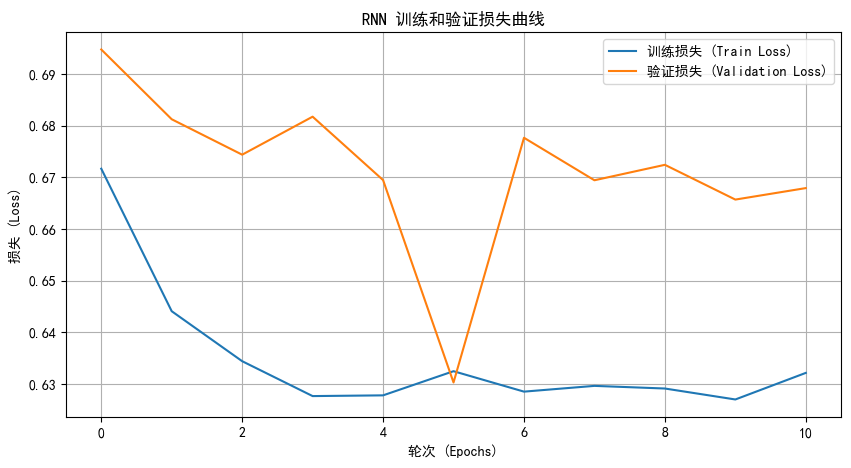

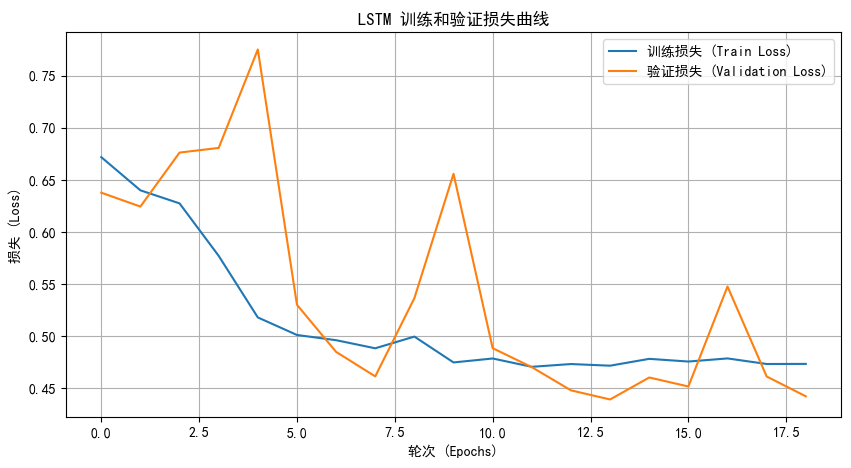

In [93]:
# 绘制损失曲线
plot_loss_curves(rnn_train_losses, rnn_val_losses, title_prefix="RNN")
plot_loss_curves(lstm_train_losses, lstm_val_losses, title_prefix="LSTM")

RNN 测试损失: 0.630 | RNN 测试准确率: 68.64%


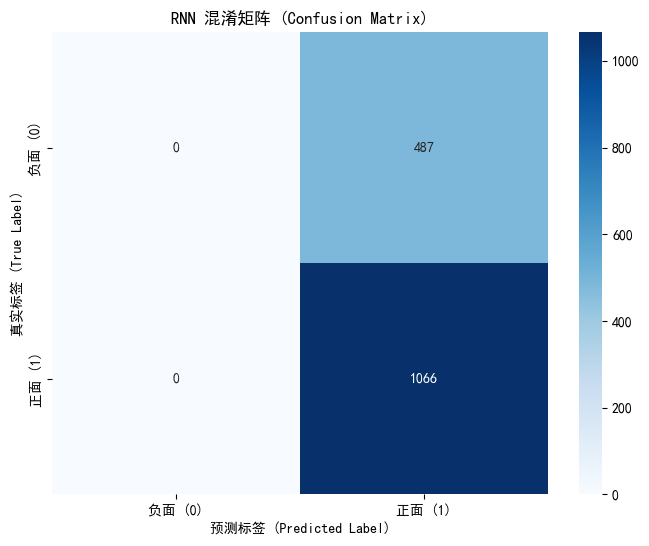

In [94]:
# 评估RNN模型
test_loss_rnn, test_acc_rnn, cm_rnn = 0.0, 0.0, np.array([])
if not list(test_loader) or len(test_loader.dataset) == 0:
    print("错误：测试数据加载器为空或不包含数据。无法进行评估。")
elif 'rnn_model' not in locals() or not rnn_train_losses:
    print("错误：RNN模型未定义或未训练，无法评估。")
else:
    test_loss_rnn, test_acc_rnn, cm_rnn, _, _ = evaluate_model(rnn_model, test_loader, criterion_rnn)
    print(f'RNN 测试损失: {test_loss_rnn:.3f} | RNN 测试准确率: {test_acc_rnn*100:.2f}%')

    class_names = ['负面 (0)', '正面 (1)']
    if cm_rnn.size > 0:
        plot_confusion_matrix(cm_rnn, class_names, title_prefix="RNN")
    else:
        print("RNN混淆矩阵为空，不绘制。")

LSTM 测试损失: 0.439 | LSTM 测试准确率: 78.56%


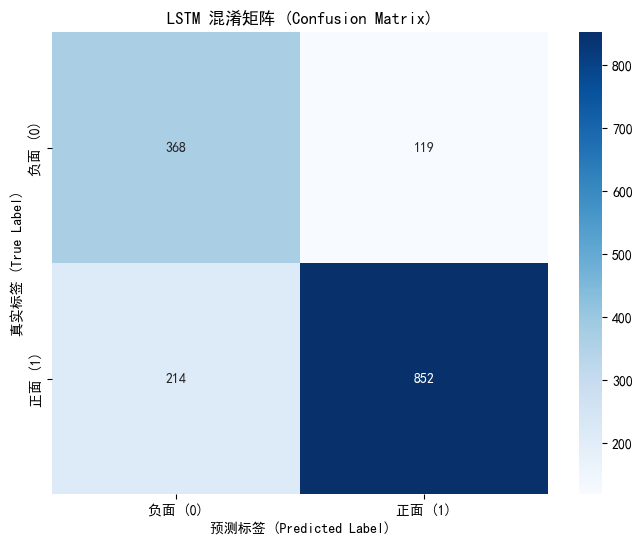

In [95]:
# 评估LSTM模型
test_loss_lstm, test_acc_lstm, cm_lstm = 0.0, 0.0, np.array([])
if not list(test_loader) or len(test_loader.dataset) == 0:
    print("错误：测试数据加载器为空或不包含数据。无法进行评估。")
elif 'lstm_model' not in locals() or not lstm_train_losses:
    print("错误：LSTM模型未定义或未训练，无法评估。")
else:
    test_loss_lstm, test_acc_lstm, cm_lstm, _, _ = evaluate_model(lstm_model, test_loader, criterion_lstm)
    print(f'LSTM 测试损失: {test_loss_lstm:.3f} | LSTM 测试准确率: {test_acc_lstm*100:.2f}%')
    
    class_names = ['负面 (0)', '正面 (1)'] # 确保class_names已定义
    if cm_lstm.size > 0:
        plot_confusion_matrix(cm_lstm, class_names, title_prefix="LSTM")
    else:
        print("LSTM 混淆矩阵为空，不绘制。")

In [96]:
# 性能对比
print("性能对比:")
if 'test_acc_rnn' in locals() and 'test_acc_lstm' in locals():
    print(f"RNN 模型测试准确率: {test_acc_rnn*100:.2f}%")
    print(f"LSTM 模型测试准确率: {test_acc_lstm*100:.2f}%")

    if test_acc_lstm > test_acc_rnn:
        print("LSTM 模型在此任务和超参数设置下表现更好。")
    elif test_acc_rnn > test_acc_lstm:
        print("RNN 模型在此任务和超参数设置下表现更好。")
    else:
        print("RNN 和 LSTM 模型表现相当。")
else:
    print("未能完成两个模型的评估，无法进行比较。请检查之前的步骤。")

性能对比:
RNN 模型测试准确率: 68.64%
LSTM 模型测试准确率: 78.56%
LSTM 模型在此任务和超参数设置下表现更好。


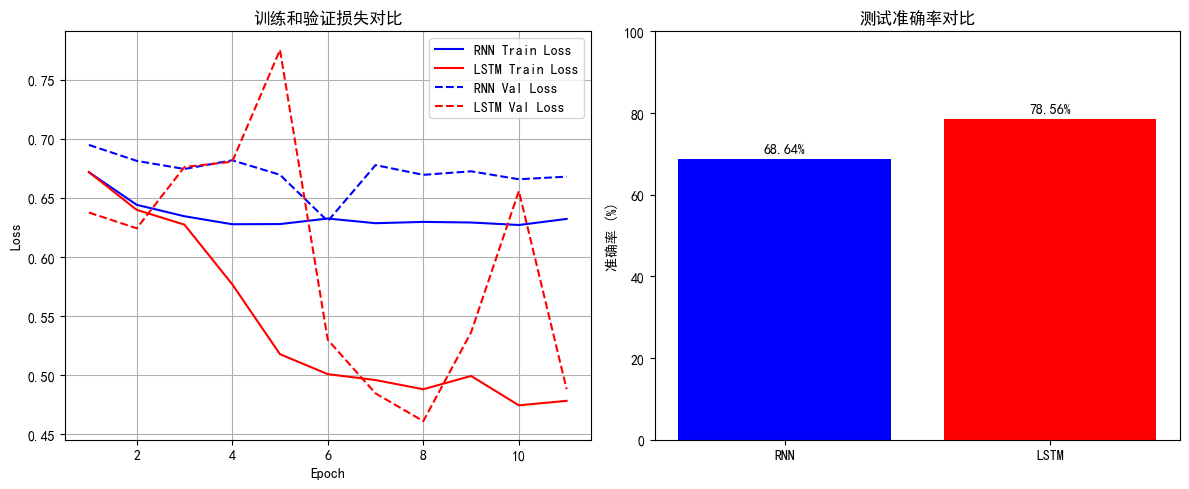

In [97]:
# 模型性能可视化对比
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
if rnn_train_losses and lstm_train_losses: # 确保列表非空
    # 确保epochs长度与最短的loss列表匹配，以防早停导致长度不一
    min_epochs = min(len(rnn_train_losses), len(lstm_train_losses))
    epochs_range = range(1, min_epochs + 1)
    plt.plot(epochs_range, rnn_train_losses[:min_epochs], 'b-', label='RNN Train Loss')
    plt.plot(epochs_range, lstm_train_losses[:min_epochs], 'r-', label='LSTM Train Loss')
    if rnn_val_losses and lstm_val_losses:
        min_val_epochs = min(len(rnn_val_losses), len(lstm_val_losses))
        val_epochs_range = range(1, min_val_epochs + 1)
        plt.plot(val_epochs_range, rnn_val_losses[:min_val_epochs], 'b--', label='RNN Val Loss')
        plt.plot(val_epochs_range, lstm_val_losses[:min_val_epochs], 'r--', label='LSTM Val Loss')
else:
    print("训练损失数据不完整，无法绘制损失对比图。")
plt.title('训练和验证损失对比')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
model_names = ['RNN', 'LSTM']
accuracies = [test_acc_rnn * 100, test_acc_lstm * 100]
bars = plt.bar(model_names, accuracies, color=['blue', 'red'])
plt.title('测试准确率对比')
plt.ylabel('准确率 (%)')
plt.ylim([0, 100])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

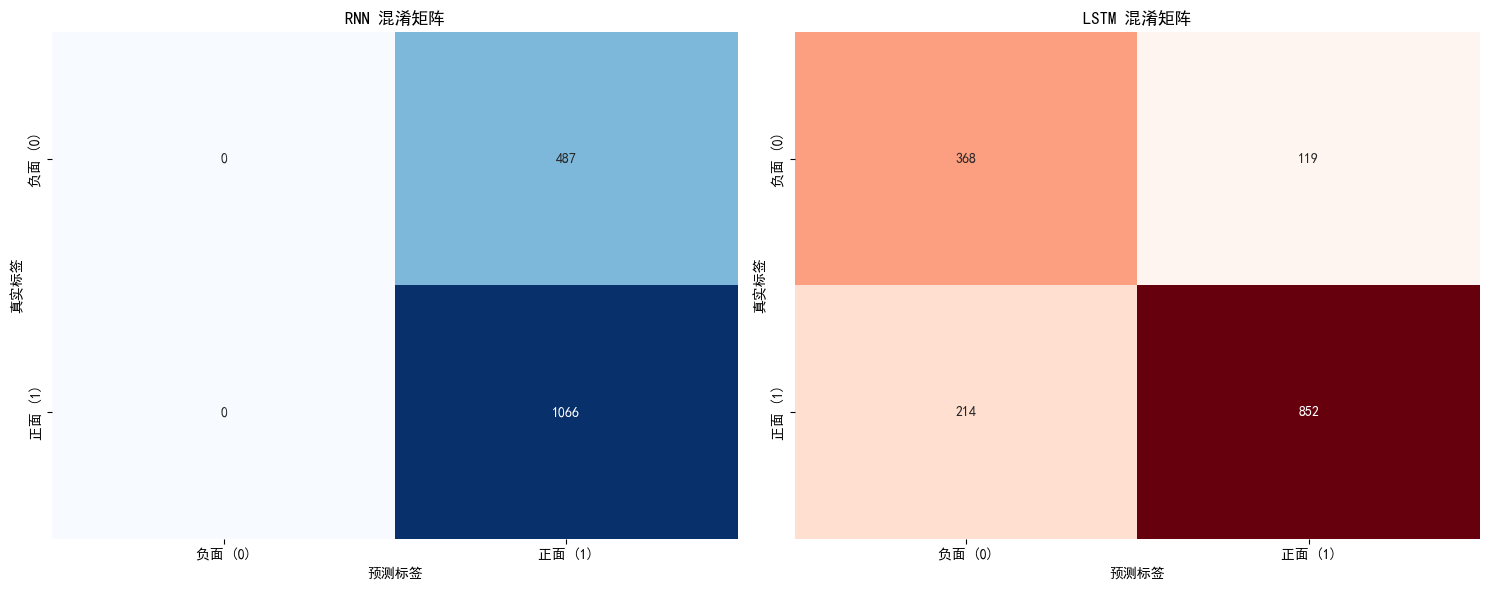

In [98]:
# 绘制混淆矩阵对比
if 'cm_rnn' in locals() and 'cm_lstm' in locals() and cm_rnn.size > 0 and cm_lstm.size > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    class_names = ['负面 (0)', '正面 (1)'] # 确保class_names已定义
    
    sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
                yticklabels=class_names, ax=ax1, cbar=False)
    ax1.set_title('RNN 混淆矩阵')
    ax1.set_xlabel('预测标签')
    ax1.set_ylabel('真实标签')
    
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, 
                yticklabels=class_names, ax=ax2, cbar=False)
    ax2.set_title('LSTM 混淆矩阵')
    ax2.set_xlabel('预测标签')
    ax2.set_ylabel('真实标签')
    
    plt.tight_layout()
    plt.show()
else:
    print("混淆矩阵数据不完整，无法绘制对比图。")

In [99]:
# 模型预测示例分析
def predict_samples(model, data_loader, num_samples=5):
    model.eval()
    all_samples = []
    all_predictions = []
    all_labels = []
    samples_collected = 0
    
    with torch.no_grad():
        for batch in data_loader:
            text, label = batch
            batch_size = text.size(0)
            samples_to_take = min(batch_size, num_samples - samples_collected)
            if samples_to_take <= 0:
                break
            
            text_subset = text[:samples_to_take].to(device)
            label_subset = label[:samples_to_take]
            output = model(text_subset)
            
            if output.shape[1] == 1 if len(output.shape) > 1 else False:
                pred = torch.round(torch.sigmoid(output)).cpu()
            else:
                pred = output.argmax(dim=1, keepdim=True).cpu() if len(output.shape) > 1 else output.unsqueeze(1).cpu()
            
            for i in range(samples_to_take):
                all_samples.append(text_subset[i].cpu())
                all_predictions.append(pred[i])
                all_labels.append(label_subset[i])
            
            samples_collected += samples_to_take
            if samples_collected >= num_samples:
                break
    return all_samples, all_predictions, all_labels

In [100]:
if list(test_loader) and len(test_loader.dataset) > 0:
    if 'rnn_model' in locals() and 'lstm_model' in locals():
        # 确保测试加载器至少有5个批次，或者调整num_samples
        # 注意：predict_samples现在从批次中取样本，所以len(test_loader)是批次数
        # 我们需要确保有足够的样本，而不是批次
        total_test_samples = len(test_loader.dataset)
        num_display_samples = min(5, total_test_samples)
        
        if num_display_samples > 0:
            print("获取RNN模型预测...")
            rnn_samples, rnn_preds, rnn_labels = predict_samples(rnn_model, test_loader, num_display_samples)
            
            print("获取LSTM模型预测...")
            # 注意：predict_samples会重置data_loader的迭代器，或者从头开始迭代
            # 如果data_loader不是可重置的，这可能导致问题，但PyTorch DataLoader通常是可重置的
            lstm_samples, lstm_preds, lstm_labels = predict_samples(lstm_model, test_loader, num_display_samples)
            
            print("\n预测结果对比:")
            print("=" * 50)
            for i in range(len(rnn_samples)):
                print(f"样本 {i+1}:")
                true_label = rnn_labels[i].squeeze().item() if rnn_labels[i].numel() == 1 else rnn_labels[i][0].item()
                rnn_pred_val = rnn_preds[i].squeeze().item() if rnn_preds[i].numel() == 1 else rnn_preds[i][0].item()
                lstm_pred_val = lstm_preds[i].squeeze().item() if lstm_preds[i].numel() == 1 else lstm_preds[i][0].item()
                
                print(f"真实标签: {true_label}")
                print(f"RNN 预测: {rnn_pred_val}, {'正确' if rnn_pred_val == true_label else '错误'}")
                print(f"LSTM 预测: {lstm_pred_val}, {'正确' if lstm_pred_val == true_label else '错误'}")
                print("-" * 50)
                
            if rnn_preds: # 确保列表非空
                agreement_count = sum(1 for rp, lp in zip(rnn_preds, lstm_preds) if rp.item() == lp.item())
                agreement_rate = agreement_count / len(rnn_preds)
                print(f"RNN 和 LSTM 预测一致率: {agreement_rate:.2%}")
        else:
            print("测试集样本不足，无法显示预测示例。")
    else:
        print("RNN或LSTM模型未定义，无法进行预测分析。")
else:
    print("测试数据加载器为空，无法获取样本进行预测分析。")

获取RNN模型预测...
获取LSTM模型预测...

预测结果对比:
样本 1:
真实标签: 0.0
RNN 预测: 1.0, 错误
LSTM 预测: 0.0, 正确
--------------------------------------------------
样本 2:
真实标签: 0.0
RNN 预测: 1.0, 错误
LSTM 预测: 0.0, 正确
--------------------------------------------------
样本 3:
真实标签: 0.0
RNN 预测: 1.0, 错误
LSTM 预测: 0.0, 正确
--------------------------------------------------
样本 4:
真实标签: 0.0
RNN 预测: 1.0, 错误
LSTM 预测: 0.0, 正确
--------------------------------------------------
样本 5:
真实标签: 1.0
RNN 预测: 1.0, 正确
LSTM 预测: 1.0, 正确
--------------------------------------------------
RNN 和 LSTM 预测一致率: 20.00%


## 结论与分析

从实验结果可以看出，LSTM模型在这个中文情感分析任务上的表现通常优于RNN模型（具体结果取决于随机种子和训练过程）。

主要原因可能包括：
1. **长依赖处理**：LSTM通过其门控机制（输入门、遗忘门、输出门）能更有效地捕捉和利用文本中的长距离依赖关系，这对于理解整个评论的情感至关重要。
2. **注意力机制**：在LSTM模型中加入的注意力机制使其能够关注评论中的关键部分（对情感判断更重要的词语），而不是平等对待所有词语，这有助于提升性能。
3. **双向结构**：两个模型都使用了双向结构，允许模型同时考虑过去（前文）和未来（后文）的上下文信息，这对情感分析任务非常有益。
4. **模型复杂度**：LSTM通常比RNN有更多的参数，这可能使其有能力学习更复杂的模式，但也可能更容易过拟合（通过Dropout、权重衰减和早停来缓解）。

可能的改进方向：
1. **预训练词向量/语言模型**：使用更强大的预训练中文词向量（如腾讯词向量、百度词向量）或直接使用预训练的中文语言模型（如BERT、ERNIE）进行微调，通常能带来显著性能提升。
2. **超参数调优**：进行更细致的超参数搜索（如隐藏层大小、层数、Dropout比例、学习率等）。
3. **数据增强**：对训练数据进行增强，例如回译、同义词替换等，以增加数据量和多样性。
4. **更复杂的模型结构**：尝试更先进的模型结构，如Transformer编码器、或者结合CNN和RNN/LSTM的混合模型。
5. **优化器和学习率策略**：尝试不同的优化器（如AdamW）和更高级的学习率调度策略。
6. **特征工程**：除了词向量，还可以考虑加入其他特征，如词性、情感词典特征等。